# Introduction to Text Mining and Natural Language Processing


In [1]:
import numpy as np
import pandas as pd 
from warnings import filterwarnings
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing  import LabelEncoder
from sklearn.model_selection import GridSearchCV,cross_validate,cross_val_score
from nltk.corpus import stopwords
from nltk.sentiment import SentimentIntensityAnalyzer
from textblob import Word, TextBlob
from wordcloud import WordCloud
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer


In [2]:
filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 200)
pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [3]:
df=pd.read_csv('amazon_reviews.csv')

In [4]:
df.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,day_diff,helpful_yes,total_vote
0,A3SBTW3WS4IQSN,B007WTAJTO,NaN,"[0, 0]",No issues.,4.00,Four Stars,1406073600,2014-07-23,138,0,0
1,A18K1ODH1I2MVB,B007WTAJTO,0mie,"[0, 0]","Purchased this for my device, it worked as adv...",5.00,MOAR SPACE!!!,1382659200,2013-10-25,409,0,0
2,A2FII3I2MBMUIA,B007WTAJTO,1K3,"[0, 0]",it works as expected. I should have sprung for...,4.00,nothing to really say....,1356220800,2012-12-23,715,0,0
3,A3H99DFEG68SR,B007WTAJTO,1m2,"[0, 0]",This think has worked out great.Had a diff. br...,5.00,Great buy at this price!!! *** UPDATE,1384992000,2013-11-21,382,0,0
4,A375ZM4U047O79,B007WTAJTO,2&amp;1/2Men,"[0, 0]","Bought it with Retail Packaging, arrived legit...",5.00,best deal around,1373673600,2013-07-13,513,0,0


In [5]:
df.shape

(4915, 12)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4915 entries, 0 to 4914
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   reviewerID      4915 non-null   object 
 1   asin            4915 non-null   object 
 2   reviewerName    4914 non-null   object 
 3   helpful         4915 non-null   object 
 4   reviewText      4914 non-null   object 
 5   overall         4915 non-null   float64
 6   summary         4915 non-null   object 
 7   unixReviewTime  4915 non-null   int64  
 8   reviewTime      4915 non-null   object 
 9   day_diff        4915 non-null   int64  
 10  helpful_yes     4915 non-null   int64  
 11  total_vote      4915 non-null   int64  
dtypes: float64(1), int64(4), object(7)
memory usage: 460.9+ KB


## 1. Text Preprocessing

In [7]:
# Normalizing Case Folding
df['reviewText'] = df['reviewText'].str.lower()

# Punctuations
df['reviewText'] = df['reviewText'].str.replace('[^\w\s]', '')

# Numbers
df['reviewText'] = df['reviewText'].str.replace('\d', '')

In [8]:
# Stopwords

sw = stopwords.words('english')
df['reviewText'] = df['reviewText'].apply(lambda x: " ".join(x for x in str(x).split() if x not in sw))

In [9]:
# Rarewords

drops = pd.Series(' '.join(df['reviewText']).split()).value_counts()[-1000:]
df['reviewText'] = df['reviewText'].apply(lambda x: " ".join(x for x in x.split() if x not in drops))

In [10]:
# Tokenization

# nltk.download("punkt")
df["reviewText"].apply(lambda x: TextBlob(x).words).head()

0                                             [issues]
1    [purchased, device, worked, advertised, never,...
2    [works, expected, sprung, higher, capacity, th...
3    [think, worked, greathad, diff, bran, gb, card...
4    [bought, retail, packaging, arrived, legit, or...
Name: reviewText, dtype: object

In [11]:
# Lemmatization
df['reviewText'] = df['reviewText'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))

df['reviewText'].head(10)

0                                                issue
1    purchased device worked advertised never much ...
2    work expected sprung higher capacity think mad...
3    think worked greathad diff bran gb card went s...
4    bought retail packaging arrived legit orange e...
5    mini storage doesnt anything else supposed pur...
6    phone never skip beat file transfer speedy cor...
7    hard believe affordable digital become gb devi...
8    work htc rezound running short space gb sandis...
9    galaxy super fast card totally happy happy sti...
Name: reviewText, dtype: object

# 2. Text Visualization

In [12]:
tf = df["reviewText"].apply(lambda x: pd.value_counts(x.split(" "))).sum(axis=0).reset_index()

tf.columns = ["words", "tf"]
tf.head()

,words,tf
0,issue,609.00
1,purchased,344.00
2,device,584.00
3,worked,460.00
4,advertised,111.00


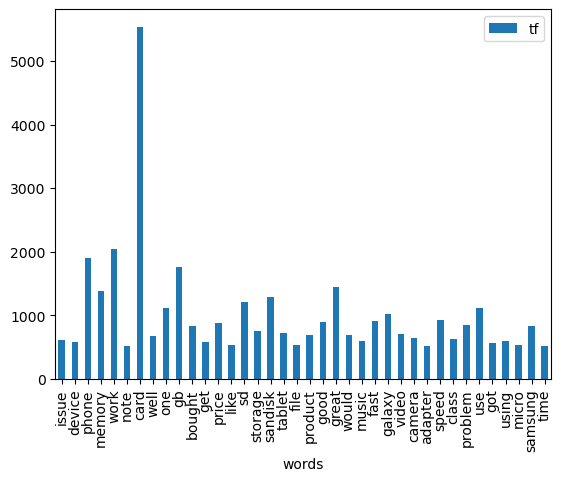

In [13]:
# Barplot

tf[tf["tf"] > 500].plot.bar(x="words", y="tf")
plt.show()

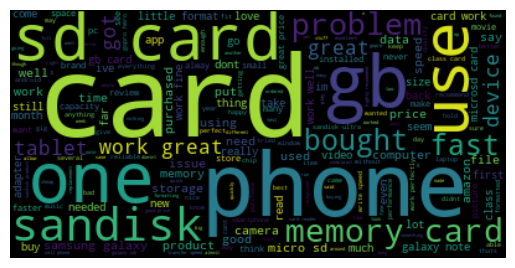

In [14]:
# Wordcloud

text = " ".join(i for i in df.reviewText)
wordcloud = WordCloud().generate(text)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

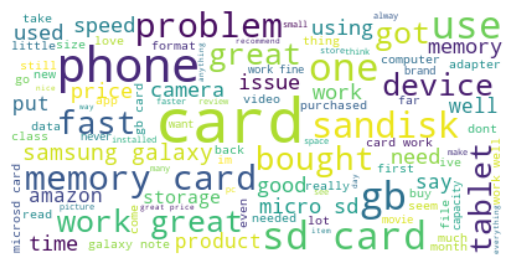

In [15]:
# daha açık renkli bir grafik
wordcloud = WordCloud(max_font_size=50,
                      max_words=100,
                      background_color="white").generate(text)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

wordcloud.to_file("wordcloud.png")

# 3. Sentiment Analysis

In [16]:
df.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,day_diff,helpful_yes,total_vote
0,A3SBTW3WS4IQSN,B007WTAJTO,NaN,"[0, 0]",issue,4.00,Four Stars,1406073600,2014-07-23,138,0,0
1,A18K1ODH1I2MVB,B007WTAJTO,0mie,"[0, 0]",purchased device worked advertised never much ...,5.00,MOAR SPACE!!!,1382659200,2013-10-25,409,0,0
2,A2FII3I2MBMUIA,B007WTAJTO,1K3,"[0, 0]",work expected sprung higher capacity think mad...,4.00,nothing to really say....,1356220800,2012-12-23,715,0,0
3,A3H99DFEG68SR,B007WTAJTO,1m2,"[0, 0]",think worked greathad diff bran gb card went s...,5.00,Great buy at this price!!! *** UPDATE,1384992000,2013-11-21,382,0,0
4,A375ZM4U047O79,B007WTAJTO,2&amp;1/2Men,"[0, 0]",bought retail packaging arrived legit orange e...,5.00,best deal around,1373673600,2013-07-13,513,0,0


In [17]:
sia = SentimentIntensityAnalyzer()  #It's used to analyze the sentiment of a given text, determining whether the text is positive, negative, or neutral.

In [18]:
sia.polarity_scores("The film was awesome")


{'neg': 0.0, 'neu': 0.423, 'pos': 0.577, 'compound': 0.6249}

In [19]:
sia.polarity_scores("I liked this music but it is not good as the other one")


{'neg': 0.207, 'neu': 0.666, 'pos': 0.127, 'compound': -0.298}

In [20]:
#calculating score for 10 
df["reviewText"][0:10].apply(lambda x: sia.polarity_scores(x))

0    {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
1    {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
2    {'neg': 0.0, 'neu': 0.828, 'pos': 0.172, 'comp...
3    {'neg': 0.0, 'neu': 0.831, 'pos': 0.169, 'comp...
4    {'neg': 0.0, 'neu': 0.765, 'pos': 0.235, 'comp...
5    {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
6    {'neg': 0.099, 'neu': 0.589, 'pos': 0.312, 'co...
7    {'neg': 0.066, 'neu': 0.703, 'pos': 0.231, 'co...
8    {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
9    {'neg': 0.0, 'neu': 0.457, 'pos': 0.543, 'comp...
Name: reviewText, dtype: object

In [21]:
#Chose component from the dictionary
df["reviewText"][0:10].apply(lambda x: sia.polarity_scores(x)["compound"])

0   0.00
1   0.00
2   0.40
3   0.65
4   0.86
5   0.00
6   0.90
7   0.82
8   0.00
9   0.92
Name: reviewText, dtype: float64

In [22]:

df["polarity_score"] = df["reviewText"].apply(lambda x: sia.polarity_scores(x)["compound"])
df.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,day_diff,helpful_yes,total_vote,polarity_score
0,A3SBTW3WS4IQSN,B007WTAJTO,NaN,"[0, 0]",issue,4.00,Four Stars,1406073600,2014-07-23,138,0,0,0.00
1,A18K1ODH1I2MVB,B007WTAJTO,0mie,"[0, 0]",purchased device worked advertised never much ...,5.00,MOAR SPACE!!!,1382659200,2013-10-25,409,0,0,0.00
2,A2FII3I2MBMUIA,B007WTAJTO,1K3,"[0, 0]",work expected sprung higher capacity think mad...,4.00,nothing to really say....,1356220800,2012-12-23,715,0,0,0.40
3,A3H99DFEG68SR,B007WTAJTO,1m2,"[0, 0]",think worked greathad diff bran gb card went s...,5.00,Great buy at this price!!! *** UPDATE,1384992000,2013-11-21,382,0,0,0.65
4,A375ZM4U047O79,B007WTAJTO,2&amp;1/2Men,"[0, 0]",bought retail packaging arrived legit orange e...,5.00,best deal around,1373673600,2013-07-13,513,0,0,0.86


## 4. Sentiment Modeling

In [23]:
#Feature engineering 

df["reviewText"][0:10].apply(lambda x: "pos" if sia.polarity_scores(x)["compound"] > 0 else "neg")


0    neg
1    neg
2    pos
3    pos
4    pos
5    neg
6    pos
7    pos
8    neg
9    pos
Name: reviewText, dtype: object

In [24]:
df["sentiment_label"] = df["reviewText"].apply(lambda x: "pos" if sia.polarity_scores(x)["compound"] > 0 else "neg")
df.head(20)

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,day_diff,helpful_yes,total_vote,polarity_score,sentiment_label
0,A3SBTW3WS4IQSN,B007WTAJTO,NaN,"[0, 0]",issue,4.00,Four Stars,1406073600,2014-07-23,138,0,0,0.00,neg
1,A18K1ODH1I2MVB,B007WTAJTO,0mie,"[0, 0]",purchased device worked advertised never much ...,5.00,MOAR SPACE!!!,1382659200,2013-10-25,409,0,0,0.00,neg
2,A2FII3I2MBMUIA,B007WTAJTO,1K3,"[0, 0]",work expected sprung higher capacity think mad...,4.00,nothing to really say....,1356220800,2012-12-23,715,0,0,0.40,pos
3,A3H99DFEG68SR,B007WTAJTO,1m2,"[0, 0]",think worked greathad diff bran gb card went s...,5.00,Great buy at this price!!! *** UPDATE,1384992000,2013-11-21,382,0,0,0.65,pos
4,A375ZM4U047O79,B007WTAJTO,2&amp;1/2Men,"[0, 0]",bought retail packaging arrived legit orange e...,5.00,best deal around,1373673600,2013-07-13,513,0,0,0.86,pos
5,A2IDCSC6NVONIZ,B007WTAJTO,2Cents!,"[0, 0]",mini storage doesnt anything else supposed pur...,5.00,Not a lot to really be said,1367193600,2013-04-29,588,0,0,0.00,neg
6,A26YHXZD5UFPVQ,B007WTAJTO,2K1Toaster,"[0, 0]",phone never skip beat file transfer speedy cor...,5.00,Works well,1382140800,2013-10-19,415,0,0,0.90,pos
7,A3CW0ZLUO5X2B1,B007WTAJTO,"35-year Technology Consumer ""8-tracks to 802.11""","[0, 0]",hard believe affordable digital become gb devi...,5.00,32 GB for less than two sawbucks...what's not ...,1404950400,2014-10-07,62,0,0,0.82,pos
8,A2CYJO155QP33S,B007WTAJTO,4evryoung,"[1, 1]",work htc rezound running short space gb sandis...,5.00,Loads of room,1395619200,2014-03-24,259,1,1,0.00,neg
9,A2S7XG3ZC4VGOQ,B007WTAJTO,53rdcard,"[0, 0]",galaxy super fast card totally happy happy sti...,5.00,works great,1381449600,2013-11-10,393,0,0,0.92,pos


In [25]:
df["sentiment_label"].value_counts()

pos    3946
neg     969
Name: sentiment_label, dtype: int64

In [26]:
df.groupby("sentiment_label")["overall"].mean()


sentiment_label
neg   4.09
pos   4.71
Name: overall, dtype: float64

In [27]:
# Labelencoding
df["sentiment_label"] = LabelEncoder().fit_transform(df["sentiment_label"])

X = df["reviewText"]
y = df["sentiment_label"]

In [28]:
vectorizer = CountVectorizer()
X_count = vectorizer.fit_transform(X)
vectorizer.get_feature_names_out()[10:15]
X_count.toarray()[10:15]

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [29]:
#
tf_idf_word_vectorizer = TfidfVectorizer()
X_tf_idf_word = tf_idf_word_vectorizer.fit_transform(X)

# 5. Modeling

In [30]:
# Logistic Regression

log_model = LogisticRegression().fit(X_tf_idf_word, y)

cross_val_score(log_model,
                X_tf_idf_word,
                y, scoring="accuracy",
                cv=5).mean()

yeni_yorum = pd.Series("this product is great")
yeni_yorum = pd.Series("look at that shit very bad")
yeni_yorum = pd.Series("it was good but I am sure that it fits me")

yeni_yorum = CountVectorizer().fit(X).transform(yeni_yorum)
log_model.predict(yeni_yorum)

array([1])

In [31]:

random_review = pd.Series(df["reviewText"].sample(1).values)
random_review

0    used sd psp adapter work fine game stored memo...
dtype: object

In [32]:
yeni_yorum = CountVectorizer().fit(X).transform(random_review)
log_model.predict(yeni_yorum)

array([1])

### Random Forests¶


In [33]:
# Count Vectors
rf_model = RandomForestClassifier().fit(X_count, y)
cross_val_score(rf_model, X_count, y, cv=5, n_jobs=-1).mean()

0.8284842319430314

In [34]:
# TF-IDF Word-Level
rf_model = RandomForestClassifier().fit(X_tf_idf_word, y)
cross_val_score(rf_model, X_tf_idf_word, y, cv=5, n_jobs=-1).mean()

0.8209562563580877

In [36]:
rf_model = RandomForestClassifier(random_state=17)

In [37]:
rf_params = {"max_depth": [5, 8, None],
             "max_features": [5, 7, "auto"],
             "min_samples_split": [2, 5, 8, 20],
             "n_estimators": [100, 200, 500]}

In [38]:
rf_best_grid = GridSearchCV(rf_model,rf_params,cv=5,n_jobs=-1,verbose=True).fit(X_count, y)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


In [39]:
rf_best_grid.best_params_


{'max_depth': None,
 'max_features': 'auto',
 'min_samples_split': 2,
 'n_estimators': 100}

In [42]:
rf_final = rf_model.set_params(**rf_best_grid.best_params_, random_state=17).fit(X_count, y)


In [43]:
cv_results = cross_validate(rf_final, X_count, y, cv=3, scoring=["accuracy", "f1", "roc_auc"])

In [44]:
rf_best_grid.best_params_

{'max_depth': None,
 'max_features': 'auto',
 'min_samples_split': 2,
 'n_estimators': 100}

In [45]:
rf_final = rf_model.set_params(**rf_best_grid.best_params_, random_state=17).fit(X_count, y)


In [ ]:
cv_results = cross_validate(rf_final, X_count, y, cv=3, scoring=["accuracy", "f1", "roc_auc"])


In [48]:
cv_results

{'fit_time': array([6.73411131, 6.36590433, 7.84759569]),
 'score_time': array([0.09377766, 0.13100219, 0.10599852]),
 'test_accuracy': array([0.8242831 , 0.83089133, 0.83028083]),
 'test_f1': array([0.90068966, 0.90391953, 0.9027972 ]),
 'test_roc_auc': array([0.86890215, 0.88391035, 0.86052455])}